## Intro to deep learning for medical imaging by [MD.ai](https://www.md.ai)

## Lesson 2. Lung X-Rays Semantic Segmentation

This lesson applies a [U-Net for Semantic Segmentation](https://arxiv.org/abs/1505.04597) of the lung fields on chest x-rays.

The MD.ai annotator is used to view the DICOM images, and to create the image level annotation. The MD.ai python client library is then used to download images and annotations, prepare the datasets, then are then used to train the model for classification.

- MD.ai annotator project URL: https://public.md.ai/annotator/project/aGq4k6NW
- MD.ai python client libray URL: https://github.com/mdai/mdai-client-py
- MD.ai documentation URL: https://docs.md.ai

The original public dataset is found [here](https://ceb.nlm.nih.gov/repositories/tuberculosis-chest-x-ray-image-data-sets/). This tutorial and use of this public dataset is for education purpose only. Note that any publications resulting from the use of this data must attribute the data to National Library of Medicine, National Institutes of Health, Bethesda, MD, USA, and cite this article: https://lhncbc.nlm.nih.gov/publication/pub9356  
For further information regarding the dataset, see [this faq](https://openi.nlm.nih.gov/faq.php).

**Intro to deep learning for medical imaging [lessons](https://github.com/mdai/ml-lessons) by MD.ai**

| # | Name  | GitHub  | <span>MD.ai</span>  | Colab |
|---|---|---|---|---|
| 1  | Classification of chest vs. adominal X-rays using TensorFlow/Keras | [Link](https://github.com/mdai/ml-lessons/blob/master/lesson1-xray-images-classification.ipynb) | [Link](https://public.md.ai/annotator/project/PVq9raBJ) | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mdai/ml-lessons/blob/master/lesson1-xray-images-classification.ipynb) |
| 2  | Lung X-Rays Semantic Segmentation using U-Nets | [Link](https://github.com/mdai/ml-lessons/blob/master/lesson2-lung-xrays-segmentation.ipynb) | [Link](https://public.md.ai/annotator/project/aGq4k6NW) | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mdai/ml-lessons/blob/master/lesson2-lung-xrays-segmentation.ipynb) |
| 3a | RSNA Pneumonia detection using Kaggle data format | [Link](https://github.com/mdai/ml-lessons/blob/master/lesson3-rsna-pneumonia-detection-kaggle.ipynb) | [Link](https://public.md.ai/annotator/project/LxR6zdR2) | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mdai/ml-lessons/blob/master/lesson3-rsna-pneumonia-detection-kaggle.ipynb) |
| 3b | RSNA Pneumonia detection using the <span>MD.ai</span> python client library | [Link](https://github.com/mdai/ml-lessons/blob/master/lesson3-rsna-pneumonia-detection-mdai-client-lib.ipynb) | [Link](https://public.md.ai/annotator/project/LxR6zdR2) | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mdai/ml-lessons/blob/master/lesson3-rsna-pneumonia-detection-mdai-client-lib.ipynb) |

*Copyright 2018-2020 MD.ai, Inc.   
Licensed under the Apache License, Version 2.0*

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mdai/ml-lessons/blob/master/lesson2-lung-xrays-segmentation.ipynb)

**Clink the badge above to launch this notebook on Google Colab.**
To use GPU, go to Runtime -> Change runtime type -> switch to Python 3, and turn on GPU.

### Import the `mdai` library

On Colab, run the block below to install the `mdai` client library into your python environment.

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

print(tf.__version__)

from tensorflow import test
test.is_gpu_available()

#%%bash

#pip install -q -U mdai

['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0', '/device:GPU:0']
2.2.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
from keras.backend.tensorflow_backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True         # to log device placement
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)  

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060 SUPER, pci bus id: 0000:08:00.0, compute capability: 7.5



Using TensorFlow backend.


## Issue here:
Tensorflow can't find my GPU which label as XLA_GPU

**Update**: issue solved in https://github.com/t-thanh/gpu-check

In [3]:
import mdai
mdai.__version__

'0.5.0'

### Create an `mdai` client

The mdai client requires an access token, which authenticates you as the user. To create a new token or select an existing token, navigate to the "Personal Access Tokens" tab on your user settings page at the specified MD.ai domain (e.g., public.md.ai).

**Important: keep your access tokens safe. Do not ever share your tokens.**

In [4]:
mdai_client = mdai.Client(domain='public.md.ai', access_token="xxx")

Successfully authenticated to public.md.ai.


### Define project

Define a project you have access to by passing in the project id. The project id can be found in the URL in the following format: `https://public.md.ai/annotator/project/{project_id}`.

For example, `project_id` would be `XXXX` for `https://public.md.ai/annotator/project/XXXX`.

Specify optional `path` as the data directory (if left blank, will default to current working directory).

In [5]:
p = mdai_client.project('aGq4k6NW', path='./lesson2-data')

Using path './lesson2-data' for data.
Preparing annotations export for project aGq4k6NW...                                                
Using cached annotations data for project aGq4k6NW.
Preparing images export for project aGq4k6NW...                                                     
Using cached images data for project aGq4k6NW.


### Set label ids

Selected label ids must be explicitly set by `Project#set_label_ids` method in order to prepare datasets.

In [6]:
p.show_label_groups()

Label Group, Id: G_Vdj4o2, Name: Default group
	Labels:
	Id: L_A8Jm3d, Name: Lung



In [7]:
# this maps label ids to class ids as a dict obj
labels_dict = {
    'L_A8Jm3d': 1, # Lung   
}

print(labels_dict)
p.set_labels_dict(labels_dict)

{'L_A8Jm3d': 1}


### Create the *Training* and *Validation* datasets

In [8]:
p.show_datasets() 

Datasets:
Id: D_rQLwzo, Name: Dataset



In [9]:
dataset = p.get_dataset_by_id('D_rQLwzo')
dataset.prepare()

In [10]:
image_ids = dataset.get_image_ids()
len(image_ids)

138

### Display a few images

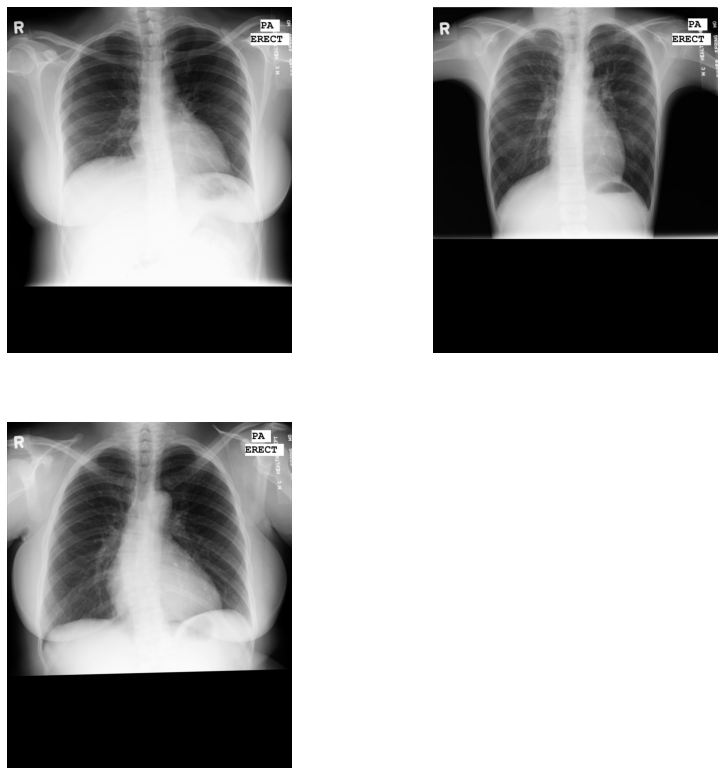

In [11]:
# visualize a few train images 
mdai.visualize.display_images(image_ids[:3], cols=2)

### Prepare datasets and model

On Colab run the following %tensorflow_version line magic function to set tensorflow to v2.

In [12]:
#%tensorflow_version 2.x

In [13]:
#%%bash

#pip install -q -U keras
#pip install -q keras-unet

In [14]:
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [15]:
imgs_anns_dict = dataset.imgs_anns_dict

In [16]:
def load_images(imgs_anns_dict, img_size=128):
    images = []
    masks = []

    for img_fp in imgs_anns_dict.keys():
        img = mdai.visualize.load_dicom_image(img_fp)
        ann = imgs_anns_dict[img_fp]

        img_width = img.shape[1]
        img_height = img.shape[0]

        mask = np.zeros((img_height, img_width), dtype=np.uint8)

        assert img.shape == mask.shape

        for a in ann:
            vertices = np.array(a['data']['vertices'])
            vertices = vertices.reshape((-1, 2))
            cv2.fillPoly(mask, np.int32([vertices]), (255, 255, 255))

        # resizing and padding
        if img.shape[0] == img.shape[1]:
            resized_shape = (img_size, img_size)
            offset = (0, 0)

        # height > width
        elif img.shape[0] > img.shape[1]:
            resized_shape = (img_size, round(img_size * img.shape[1] / img.shape[0]))
            offset = (0, (img_size - resized_shape[1]) // 2)

        else:
            resized_shape = (round(img_size * img.shape[0] / img.shape[1]), img_size)
            offset = ((img_size - resized_shape[0]) // 2, 0)

        resized_shape = (resized_shape[1], resized_shape[0])
        img_resized = cv2.resize(img, resized_shape).astype(np.uint8)
        mask_resized = cv2.resize(mask, resized_shape).astype(np.bool)

        resized_shape = (resized_shape[1], resized_shape[0])

        # add padding to square
        img_padded = np.zeros((img_size, img_size), dtype=np.uint8)
        img_padded[
            offset[0] : (offset[0] + resized_shape[0]), offset[1] : (offset[1] + resized_shape[1])
        ] = img_resized
        mask_padded = np.zeros((img_size, img_size), dtype=np.bool)
        mask_padded[
            offset[0] : (offset[0] + resized_shape[0]), offset[1] : (offset[1] + resized_shape[1])
        ] = mask_resized

        images.append(img_padded)
        masks.append(mask_padded)

    # add channel dim
    images = np.asarray(images)[:, :, :, None]
    masks = np.asarray(masks)[:, :, :, None]
    return images, masks

In [17]:
images, masks = load_images(imgs_anns_dict)

28


(-0.5, 127.5, 127.5, -0.5)

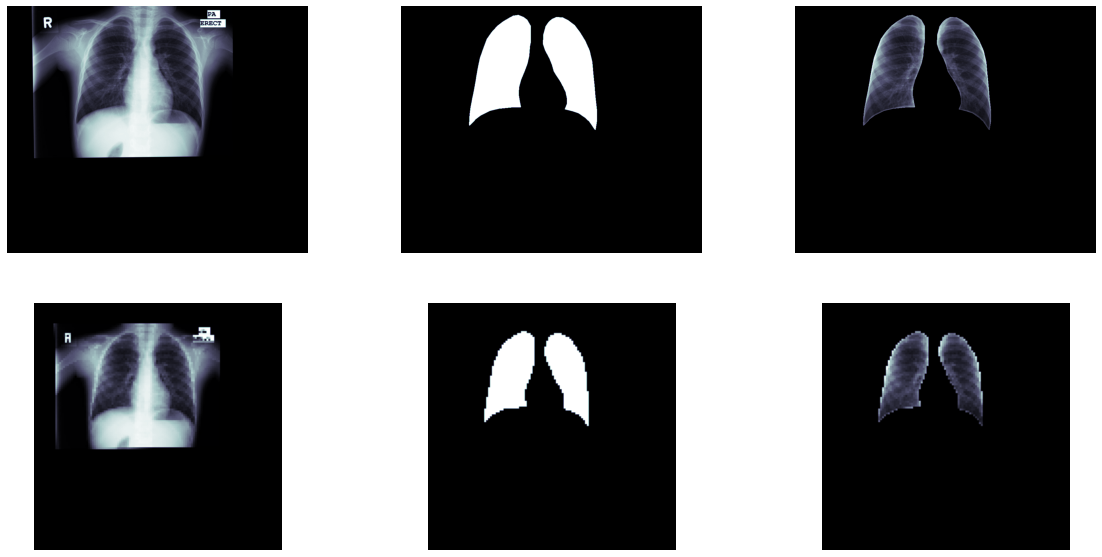

In [18]:
img_index = random.choice(range(len(imgs_anns_dict)))

print(img_index)
img_fps = list(imgs_anns_dict.keys())
img_fp = img_fps[img_index]
img = mdai.visualize.load_dicom_image(img_fp)
ann = imgs_anns_dict[img_fp]
img_width = img.shape[1]
img_height = img.shape[0]

mask = np.zeros((img_height, img_width), dtype=np.uint8) 
for a in ann:     
    vertices = np.array(a['data']['vertices'])
    vertices = vertices.reshape((-1,2))                     
    cv2.fillPoly(mask, np.int32([vertices]), (255,255,255))
    
plt.figure(figsize=(20, 10))
plt.subplot(2,3,1)
plt.imshow(img, cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(mask, cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(2,3,3)              
plt.imshow(cv2.bitwise_and(img, img, mask=mask.astype(np.uint8)), cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(2,3,4)
plt.imshow(images[img_index,:,:,0], cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(2,3,5)
plt.imshow(masks[img_index,:,:,0], cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(2,3,6)
plt.imshow(cv2.bitwise_and(images[img_index,:,:,0], images[img_index,:,:,0], 
                           mask=masks[img_index,:,:,0].astype(np.uint8)), cmap=plt.cm.bone)
plt.axis('off')

In [19]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=0)

In [20]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train, y_train, batch_size=8,
    data_gen_args = dict(
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant',
    ))

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [21]:
from keras_unet.models import custom_unet

model = custom_unet(
    x_train[0].shape,
    use_batch_norm=True,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid',
)

### Train model

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
    ModelCheckpoint('./lesson2-model/model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
]

In [23]:
from tensorflow.keras.optimizers import Adam
from keras_unet.metrics import iou

model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy', iou],
)

In [24]:
# Fix for tensorflow backend with XLA GPU
#from tensorflow.compat.v1 import InteractiveSession
#config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
#config.gpu_options.per_process_gpu_memory_fraction = 0.9
#tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config));

In [28]:
history = model.fit(
    train_gen,
    steps_per_epoch=100,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
)

Epoch 1/10


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model/conv2d/Conv2D (defined at <ipython-input-25-82852df1b7a1>:6) ]] [Op:__inference_train_function_6534]

Function call stack:
train_function


#### ISSUE:
Error when training with GPU
This issue link with jupyter, don't have problem when train with `.py` file

In [ ]:
import matplotlib.pyplot as plt

print(history.history.keys())

plt.figure()
plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.show()

In [ ]:
images, masks = load_images(imgs_anns_dict)

plt.figure(figsize=(20, 10))

img_index = random.choice(range(len(images)))

plt.subplot(1,4,1)
random_img = images[img_index,:,:,0]
plt.imshow(random_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Lung X-Ray')

plt.subplot(1,4,2)
random_mask = masks[img_index,:,:,0]
plt.imshow(random_mask, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Mask Ground Truth')

random_img_2 = np.expand_dims(np.expand_dims(random_img, axis=0), axis=3)
with tf.device('/device:CPU:0'):
    mask = model.predict(random_img_2)[0][:,:,0] > 0.5
plt.subplot(1,4,3)
plt.imshow(mask, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Predicted Mask')

plt.subplot(1,4,4)
plt.imshow(cv2.bitwise_and(random_img, random_img, mask=mask.astype(np.uint8)), cmap=plt.cm.bone)
plt.axis('off')
plt.title('Predicted Lung Segmentation')